[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/exercises/6_ex_model_assessment.ipynb) 

# Exercises for Model Assessment 

The following exercises are based on the [Model Assessment Tutorial](https://github.com/Humboldt-WI/bads/blob/master/tutorials/6_nb_model_assessment.ipynb). 
The notebook will guide you through common prediction model validation tasks to strengthen your understanding of the corresponding concepts & Python programming. Completing this exercise will bring you yet another step closer to becoming a true data scientist!

To prepare for the exercises, we will go through the following steps:
- import standard libraries and set plotting parameters
- import data and define target variable and features
- splitting the data (if you are not familiar with this concept please return to the tutorial)
- train a logit and a tree model

At this point, these tasks have become standard practice for us, so we simply provide the codes.

In [25]:
# Importing standard libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

# Set parameters for plotting
%matplotlib inline  
plt.rcParams['figure.figsize'] = (12,6)

In [26]:
# Import data
data_url = 'https://raw.githubusercontent.com/Humboldt-WI/bads/master/data/hmeq_modeling.csv' 
df = pd.read_csv(data_url, index_col='index')

# Split data into target and features
X = df.drop(['BAD'], axis=1) 
y = df['BAD']

# Zero-one encoding of the target
df['BAD'] = df['BAD'].astype(int) 

In [27]:
from sklearn.model_selection import train_test_split

# Split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=888)

In [28]:
# Estimate a logit model
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(penalty='none', fit_intercept=True)
logit.fit(X_train, y_train)

LogisticRegression(penalty='none')

In [29]:
# Estimate a CART tree
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='gini', max_depth=5)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

## Tasks 

In case you might have forgotten some general model assessment procedures, we will start with some simple tasks to get you back into the topic! 

1. Create class predictions for the tree and logit model. Save the results for task 2.

In [30]:
# Tree model
yhat_class_tree = tree.predict(X_test)

# Logit model
yhat_class_logit = logit.predict(X_test)

# Print variables to check the output
print(yhat_class_logit, yhat_class_tree)

[False False False ... False False False] [False  True False ... False False False]


2. Create the corresponding confusion matrix and manually compute, for both classifiers, the accuracy, precision and recall.

In [31]:
from sklearn import metrics 

# Tree model
cmat_tree = metrics.confusion_matrix(y_test, yhat_class_tree)

# Logit model
cmat_logit = metrics.confusion_matrix(y_test, yhat_class_logit)

# Print results to check the output
print(cmat_tree, cmat_logit, sep='\n\n')

[[1345   86]
 [ 116  241]]

[[1388   43]
 [ 268   89]]


In [32]:
# Reminder: Confusion Matrix
 
#                           predicted class
#                            0          1
#  
#                   0       TN          FP
#   true class    
#                   1       FN          TP


# Define a function to calculate precision and recall from confusion matrix

def accuracy_precision_recall(cmat_array, print_perf=True):

    # Accuracy = TN + TP / ALL
    accuracy = (cmat_array[0,0] + cmat_array[1,1])/ (cmat_array[0,0] + cmat_array[0,1] + cmat_array[1,0] + cmat_array[1,1])

    # Precision = TP / (TP+FP)
    precision = cmat_array[1,1] / (cmat_array[1,1] + cmat_array[0,1])
    
    # Recall = TP/ (TP+FN)
    recall = cmat_array[1,1] / (cmat_array[1,1] + cmat_array[1,0])


    # Add conidition to incorporate the printing of results, this will be helpful later when we only want the values
    if print_perf == True:
        print('The accuracy for the this model is: {:.4}'.format(accuracy))
        print('The precision is: {:.4}'.format(precision))
        print('The recall is: {:.4}'.format(recall))

    return(accuracy, precision, recall)




In [33]:
# Tree model
# Calculate tree performance and print the results
accuracy_precision_recall(cmat_tree, True);

The accuracy for the this model is: 0.887
The precision is: 0.737
The recall is: 0.6751


In [34]:
# Same for the logit model
accuracy_precision_recall(cmat_logit, True);

The accuracy for the this model is: 0.8261
The precision is: 0.6742
The recall is: 0.2493


Are these results representative for how good the model is? What are the shortfalls of the accuracy measure?
<br> <br>
**Answer:**
The accuracy measure shows the ratio of correctly predicted observations to all observations, meaning: How many observations did we predict correctly? The accuracy values for both models appear reasonably high, although this is hard to judge by only looking at accuracy figures. Ultimately, you would like to examine the *decision costs* of a classifier. We will do so much later in the course. Further, accuracy is an appropriate measure when the share of the classes is roughly even. This means data where we have a similar distribution between the positive and the negative class. Judging by the difference in predicted 0 and predicted 1 in the confusion matrices, this does not seem to be the case for our data set. Therefore we can look at more metrics.

Precision describes the ratio of correctly predicted positive observations. Positive in this case is 'BAD'. Hence, precision answers the questions how likely it is that a loan which we predict to default will actually default. 
 
Recall, also referred to as sensitivity, describes all the people who defaulted on their loan, and measures how many of these true defaulters we were to predict correctly.

We see comparably higher values for the tree model and relatively low scores for the logit model. However, this does not mean that the tree model is the better model of both of them. It is not fully representative of how good the model is. When making distinct predictions, we observe these measures for one specific cutoff, most commonly 0.5. The shortfall is that especially for imbalanced data set, this is not found to always be the best cutoff, which can heavily influence our model performance.

___

3. Calculate the  class probabilities for both models for class 1. Save the results for task 4.



In [35]:
# Tree model
yhat_prob_tree = tree.predict_proba(X_test)[:,1]

# Logit model
yhat_prob_logit = logit.predict_proba(X_test)[:,1]

# Print results to check the output
print(yhat_prob_logit, yhat_prob_tree, sep='\n')

[0.06558995 0.13069539 0.45878227 ... 0.19392042 0.29099327 0.16260412]
[0.06875425 0.56854839 0.06875425 ... 0.06875425 0.06875425 0.06875425]


4. Calculate the corresponding AUC values for both predictions and plot the ROC curve.

In [36]:
# Predefine functions needed for this task
def print_auc_plot_roc(X, y_true, yhat_prob, model):
  
     # Print AUC
     auc = metrics.roc_auc_score(y_true, yhat_prob)
     print('The AUC of this model is: {:.4f}'.format(auc))

     # Plot ROC curve
     metrics.plot_roc_curve(model, X, y_true) 
     plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', alpha=.8)
    
     # Return AUC value to be able to save it for later
     return auc

The AUC of this model is: 0.7923


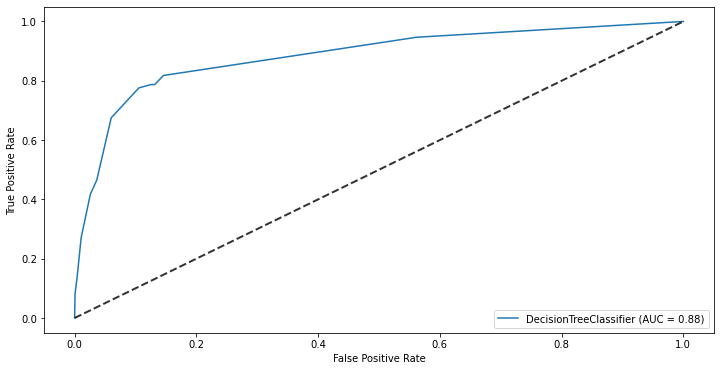

In [37]:
# Tree model 
tsk_4_auc_tree = print_auc_plot_roc(X_test, y_test, yhat_prob_logit, tree)

The AUC of this model is: 0.8835


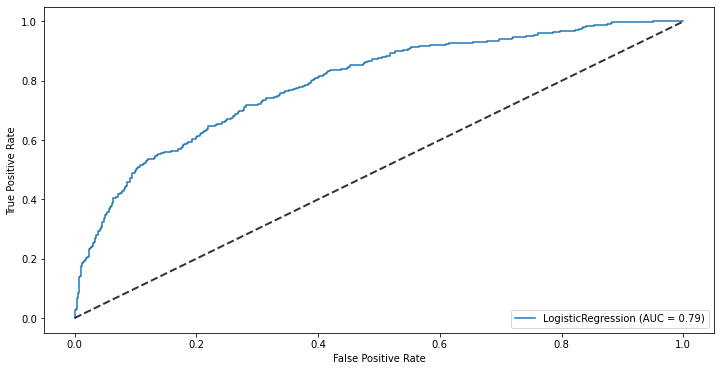

In [38]:
# Logit model
tsk_4_auc_logit =print_auc_plot_roc(X_test, y_test, yhat_prob_tree, logit)

How can we interpret this measure? Is it representative?
<br> <br>
**Answer:**
The ROC curve and AUC are an extension of the before discussed accuracy, precision and recall measures. We calculate the true positive and false positive rates and plot their trade-off in a graph over all cutoffs. We use probability predictions as the input. It tells you how well a model can distinguish between classes. As the AUC (Area Under the Curve) summarizes the ROC curve into one number, it is a great measure for comparing different models.
What AUC value indicates strong performance depends on the setting. Some settings tend to be easier to predict, so comparing models to each other in the same setting will give a good picture of how well the models have performed. However, AUC is always upper bounded by 1, the AUC of a perfect classifier. Likewise, a random classifier, represented by the dashed black line in the above plot, achieves an AUC of 0.5. So any classifier should display AUC much higher than 0.5. In our case, the tree is outperforming the logit model with an AUC of 0.85. The logit model shows an AUC of 0.76, which is still reasonably high.

____
Let's have a closer look at how the cutoffs influence our final results. 

5. Calculate the class probabilities and use these to create discrete class predictions for multiple cutoffs. Vary the cutoff from 0 to 1 in step-sizes of 0.01. Save the accuracy results and corresponding cutoffs. Finally, plot these results, with the cutoffs on the x-axis and the accuracy on the y-axis. Which cutoff gave the highest accuracy?

In [39]:
# Predefine functions

def cutoff_plot(y_true, yhat_prob):

    # Create empty variables
    accs = []
    cutoffs = []

    # Set range to loop through, 0,01 steps
    for i in np.arange(0, 1.01, 0.01): 
      
        temp = (yhat_prob >= i).astype(bool)      # create discrete predictions at cutoff
        cutoffs.append(i)                         # save cutoff value
        acc = np.sum(temp==y_true) / len(y_true)  # calculating accuracy sum(correct predictions)/ number of total predictions
        accs.append(acc)                          # save acc value

    acc_values = pd.Series(accs, index=cutoffs) # create Series saving the cutoffs as the index
    plt.plot(acc_values.index , acc_values)     # plot cutoffs and acc values as a line graph

    plt.plot(0.5, acc_values[0.5], marker='o', label= '0.5 cutoff, ACC =  {:.5f}'.format(acc_values[0.5])) # plot acc_value for 0.5 cutoff, chose marker to mark point
    
    cutoff_best_acc = acc_values.sort_values(ascending=False).index[0] # get best cutoff by extacting index by sorting the acc values from high to low 
                                                                       # and chosing the first row (index=0)

    plt.plot(cutoff_best_acc, max(acc_values), marker='o', label='highest ACC cutoff, ACC ={:.5f}'.format(max(acc_values))) # Plot cutoff with best ACC value
    plt.plot([0, 1], [max(acc_values) , max(acc_values) ], color='k', alpha=.5) # extra: plot vertical line at cutoff to check if the value appears multiple times
    plt.legend() # plot legend
    plt.xlabel('Cutoff')
    plt.ylabel('Accuracy')

    print('The highest ACC score is: {:.5f}'.format(max(acc_values)))    
    print('The corresponding cutoff is: {:.2f}'.format(cutoff_best_acc))  

    return acc_values, [cutoff_best_acc, max(acc_values)] # return variables we want to save


The highest ACC score is: 0.88702
The corresponding cutoff is: 0.50


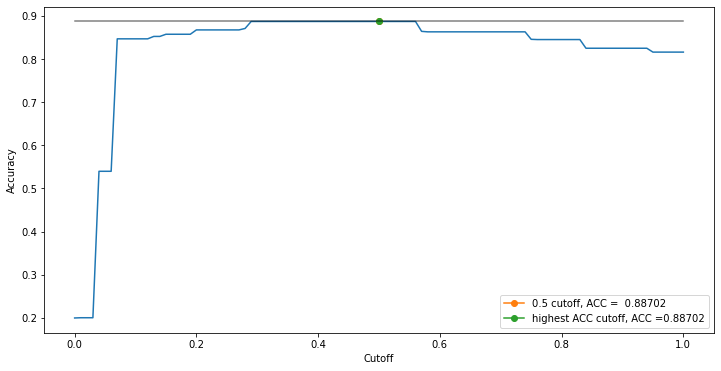

In [40]:
# Tree model
acc_values_tree, max_acc_tree = cutoff_plot(y_test, yhat_prob_tree)

In [42]:
max_acc_tree

[0.5, 0.8870246085011185]

The highest ACC score is: 0.82886
The corresponding cutoff is: 0.41


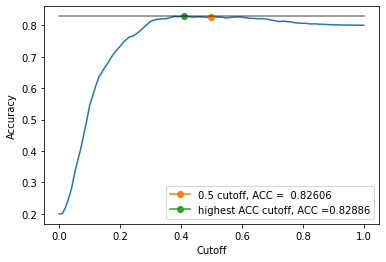

In [17]:
# Logit model
acc_values_logit, max_acc_logit = cutoff_plot(y_test, yhat_prob_logit)

Examine these results. How does the cutoff influence the prediction? The `some_model.predict() `function uses a 0.5 cutoff. How did this cutoff perform in your calculations? What cutoff would you recommend based on your results?
<br> <br>

**Answer:** Both models show a high increase in accuracy in the cutoff range of about 0.0 to 0.3. After that, the accuracy remains relatively high. Interestingly, the optimal cutoff for the tree coincides with the default cutoff of 0.5. The default cutoff is also very suitable for the logit model, although it does not give the maximal accuracy. This finding is surprising because the data set is imbalanced containing roughly 5 goods for each bad risk. Normally, class imbalance is an indicator that some tuning of the cutoff is justified; not so in this data set. As to the "what would you recommend part of the question", the whole point of tuning the cutoff is to find the best setting with maximal accuracy; assuming the accuracy is the measure that you want to optimize. You can also optimize the cutoff for other indicators like the *F-measure*, which will be introduced in the scope of [imbalanced learning](https://github.com/Humboldt-WI/bads/blob/master/tutorials/11_nb_imbalance_n_costs.ipynb). 
Further, for the tree, we see a plateau around the best cutoff with the same accuracy value, which the vertical line in the first graph reveals. The plateau and more generally the piece-wise constant shape of the tree plot is plausible when remembering that the predicted probabilities of a tree are constant in a leaf node. So a tree with e.g. 5 leaf nodes will predict five distinct probabilities value. The below plot shows how the predicted probabilities from our tree behave. The plot also hints at the fact that our above approach in `cutoff_plot()` was quite inefficient. We loop over the full range `[0.00, 0.01, 0.02, ..., 1.00]` while the number of unique probability estimates in `yhat_prob_tree` is much less. With this insight, you could easily improve the `cutoff_plot()` such that it only test the cutoff values that will actually make a difference. We leave this task to you as an additional exercise.     

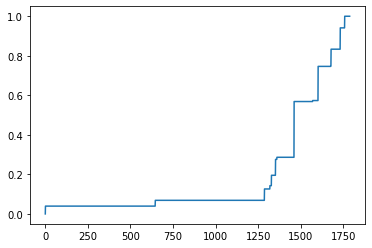

In [18]:
# Sort and plot tree prediction to get an overview of the distinct predicted probabilities
plt.plot(np.sort(yhat_prob_tree))

___

6. Use the results of your continuous predictions, extract the true and false positive rate using the function `metrics.roc_curve()` from `sklearn`, and plot a ROC curve. Re-using the cutoff that gave the largest accuracy in the previous task 5, identify the corresponding true and false positive rate. Then highlight this point on the ROC curve. Also highlight the point on the ROC curve that corresponds to a cutoff of 0.5. 

In [19]:
# Predefine functions
# Calculating fpr and tpr manually at a given cutoff
# We will use this function to plot markers at distinct point across our line graph to see where the different cutoffs are along the graph
def tpr_fpr_calc(cutoff, yhat_prob, y_true):

    # temp variable giving distinct predictions based on the cutoff given as an input
    temp = (yhat_prob >= cutoff).astype(bool)

    # Create confusion matrix for this prediction
    cmat = metrics.confusion_matrix(y_true, temp)
    
    # Calculate fpr
    fpr = cmat[1,1] / (cmat[1,1] + cmat[1,0]) # check if tpr and fpr are chosen correctly

    # Calculate TPR
    tpr = cmat[0,1]/(cmat[0,0]+cmat[0,1])

    return [cutoff, tpr, fpr,]
    

In [20]:
# Function to define the optimal cut off based on ROC curve
# EXTRA

def Find_Optimal_Cutoff(fpr, tpr, cutoffs): # inputs are tpr, fpr and cutoffs emerging from metrics.roc_curve() function

  # save fpr, tpr, tf and cutoffs in a table based on inputs
  roc = pd.DataFrame({'tpr' : pd.Series(tpr), 'fpr' : pd.Series(fpr), 'cutoff': pd.Series(cutoffs),  'tf': pd.Series(tpr - (1-fpr))})


  # Extract optimal cutoff by sorting and chosing the first row of highest absolute value of tf
  optimal = roc.iloc[(roc.tf).abs().argsort()[:1]]  
 
  return [optimal.cutoff, optimal.tpr, optimal.fpr]

In [21]:
# Tree model

# Calculate all values
fpr_tree, tpr_tree, cutoffs_tree = metrics.roc_curve(y_test, yhat_prob_tree) # calculate fpr, tpr and cutoffs using metrics.roc_curve() function

tree_cutoff_05 = tpr_fpr_calc(0.5, yhat_prob_tree, y_test) # calculate tpr and fpr for our 
print(tree_cutoff_05) # print to check if the output is correct

tree_cutoff_best_acc = tpr_fpr_calc(max_acc_tree[0], yhat_prob_tree, y_test); # repeat for cutoff with highest acc value
print(tree_cutoff_best_acc)

# EXTRA
tree_cutoff_best_roc = Find_Optimal_Cutoff(tpr_tree, fpr_tree, cutoffs_tree) # calculate optimal cutoff based on roc curve
print(tree_cutoff_best_roc)


[0.5, 0.06009783368273934, 0.6750700280112045]
[0.5, 0.06009783368273934, 0.6750700280112045]
[12    0.126214
Name: cutoff, dtype: float64, 12    0.146052
Name: tpr, dtype: float64, 12    0.817927
Name: fpr, dtype: float64]


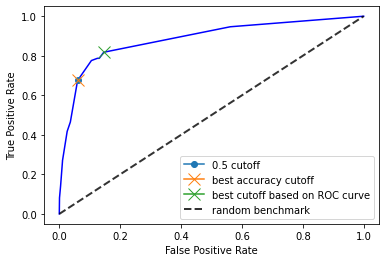

In [22]:
# Plotting 

plt.plot(fpr_tree, tpr_tree, 'b') # plot line graph of fpr and tpr for the full model


plt.plot(tree_cutoff_05[1], tree_cutoff_05[2], marker='o', label ='0.5 cutoff') # plot marker for 0.5 cutoffs corresponding fpr and tpr values
plt.plot(tree_cutoff_best_acc[1], tree_cutoff_best_acc[2], marker='x', markersize=12, label ='best accuracy cutoff') # repeat for cutoff with highest ACC value
plt.plot(tree_cutoff_best_roc[1], tree_cutoff_best_roc[2], marker ='x', markersize=12, label='best cutoff based on ROC curve') # repeat for best cutoff based on ROC curve, EXTRA


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', alpha=.8, label = 'random benchmark') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [23]:
# Logit model

fpr_logit, tpr_logit, cutoffs_logit = metrics.roc_curve(y_test, yhat_prob_logit) 

logit_cutoff_05 = tpr_fpr_calc(0.5, yhat_prob_logit, y_test)
logit_cutoff_best_acc = tpr_fpr_calc(max_acc_logit[0], yhat_prob_logit, y_test);
logit_cutoff_best_roc = Find_Optimal_Cutoff(tpr_logit, fpr_logit, cutoffs_logit)

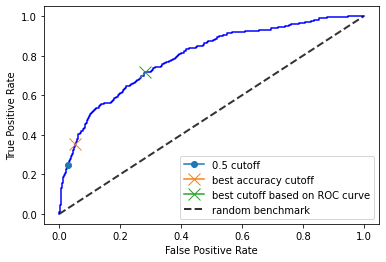

In [24]:
plt.plot(fpr_logit, tpr_logit, 'b')

plt.plot(logit_cutoff_05[1], logit_cutoff_05[2], marker='o', label ='0.5 cutoff')
plt.plot(logit_cutoff_best_acc[1], logit_cutoff_best_acc[2], marker='x', markersize=12, label ='best accuracy cutoff')
plt.plot(logit_cutoff_best_roc[1], logit_cutoff_best_roc[2], marker ='x', markersize=12, label='best cutoff based on ROC curve')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', alpha=.8, label = 'random benchmark') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

7. Manually define a cutoff in which the ratio of predictions of 0s (goods) and 1s (bads) is representative of the ratio of them in the training data. For example, if your good-to-bad ratio in the training set was 3:1, then your discrete class predictions for the test set should also display this ratio.

In [25]:
# Calculate the ratio in the training data and save the value
ratio_train = sum(y_train) / len(y_train) 
ratio_train

0.19942473633748803

In [26]:
# Tree model
# use qcut function and cutt the variable at 1-ratio train
# qcut discretizes a variable into buckets based on quantiles; we can change the cutoffs based on the percentage of observations
# if the upper ratio_train percentage (19%) is marked as 1 and the remaining as 0, the average should be almost equal to ratio_train
tree_cutoff_class= pd.qcut(yhat_prob_tree, q= [0, 1-ratio_train, 1], labels = [0, 1])
print(tree_cutoff_class.describe())
np.mean(tree_cutoff_class) # check average

            counts     freqs
categories                  
0             1461  0.817114
1              327  0.182886


0.18288590604026847

In [27]:
logit_cutoff_class = pd.qcut(yhat_prob_logit, q= [0, 1-ratio_train, 1], labels = [0, 1])
print(logit_cutoff_class.describe())
np.mean(tree_cutoff_class)

            counts     freqs
categories                  
0             1431  0.800336
1              357  0.199664


0.18288590604026847

8. Assess your classifier by creating a precision-recall plot.

In [28]:
# Predefine function for precision-recall plot

def prec_recall_plot(yhat_prob, y_true, label):
    # Empty lists to save variables 
    cutoffs = []
    precision = []
    recall = []

    # Variate cutoffs to calculate precision and recall at
    for i in np.arange(0, 1, 0.01):

        temp = (yhat_prob >= i).astype(bool)          # create distinct preiction based on cutoff
        cmat = metrics.confusion_matrix(y_true, temp) # create confusion matrix for this prediction
        _, p, r =  accuracy_precision_recall(cmat, False);    # calculate precision and recall based on the function we wrote earlier
                                                      # set bool parameter to false to avoid printing
        # Save variables 
        cutoffs.append(i)
        precision.append(p)
        recall.append(r)

    # Create datafraem from lists
    prec_recall_plot = pd.DataFrame({'cutoffs': cutoffs, 'precision': precision, 'recall': recall})

    # Plot precision and recall
    plt.plot(prec_recall_plot['recall'], prec_recall_plot['precision'], label = label )
    plt.ylim(0, 1.2)
    plt.legend()
    plt.xlabel('Recall')
    plt.ylabel('Precision')
        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars


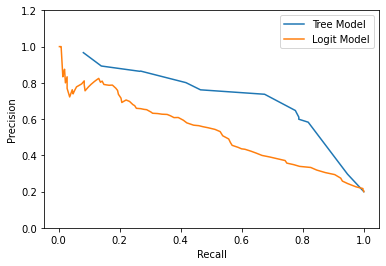

In [29]:
# Use function to plot the results for both models
prec_recall_plot(yhat_prob_tree, y_test, 'Tree Model')
prec_recall_plot(yhat_prob_logit, y_test, 'Logit Model')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars


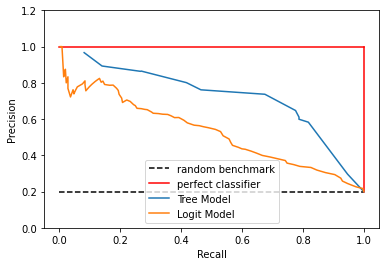

In [30]:
# EXTRA
# for further understanding/ better interpretation
plt.plot([0, 1], [ratio_train , ratio_train ], color='k', linestyle='--', label= 'random benchmark') # comparable to random benchmark in ROC curve
plt.plot([0, 1], [1,1], color='red', label = 'perfect classifier') 
plt.plot([1, 1], [ratio_train,1], color='red') 

prec_recall_plot(yhat_prob_tree, y_test, 'Tree Model')
prec_recall_plot(yhat_prob_logit, y_test, 'Logit Model')

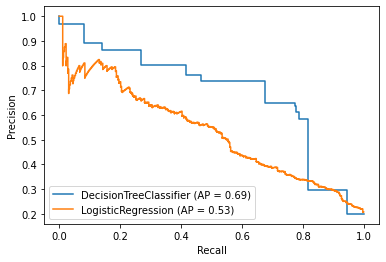

In [31]:
# As usual, functions already exist
# Use this function to directly create a precision-recall curve
from sklearn.metrics import plot_precision_recall_curve

fig, ax = plt.subplots()

plot_precision_recall_curve(tree, X_test, y_test, ax=ax)
plot_precision_recall_curve(logit, X_test, y_test, ax=ax)

How does this table differ from the ROC curve? Which of them would you use in different situations? 
<br> <br>
**Answer:** 
Precision-recall curves are another metric to assess a model and is particularly helpful when analyzing models built on an imbalanced dataset. They summarize the trade-off between precision and recall over all cutoffs, meaning the positive predicted value and the true positive rate, respectively. For this model specifically, I would use this representation, as we can have a closer look at the predicted 'bad's, which are a lot less frequent in this data set than the 'good's. This graph is only helpful when the specificity is not/less important. As it is more important for us to find out how to distinguish the class 'bad', as they are harder to identify and can cost a credit giver a lot more money, this is true for our scenario. As we can see, the tree model still seems to outperform the logit model based on the precision-recall plot.
___

Next we want to find out how the size of the training set can affect our predictions.

9. Create a loop in which you train multiple logit models. Vary a parameter `train_set_size` from 0 to 1 in steps of 0.1. In each iteration of the loop, estimate a logit model using `train_set_size` percent of the actual training set, which we created at the beginning of the exercise. Calculate the AUC for our test set for each model and save it in an array. Finally, create a plot of `train_set_size` on the x-axis versus the corresponding test set AUC on the y-axis. 

In [32]:
# Define function to variate size of training set 
def trainset_variation(model, features, target):

    # Create variables and set plot
    ts = np.linspace(0.1, 0.9, 9) # cannot use 100% for training as no test set would exist
    AUC = []
    fig, ax = plt.subplots()
    trainsize = []
    
    # Loop through different training sizes, enumerate = i for indexing
    for i, train_set_size in enumerate(ts):

      # Train-test split, but only saving train variables as we will use the existing test set 
      # To get the function to output a training set of the specified size, we will have to set the test_size to 1-train_set_size
      X_train_, _, y_train_, _ = train_test_split(features, target, test_size= (1-train_set_size), random_state=888)

      # Fit model on training set
      model.fit(X_train_, y_train_) 

      # Make continuous prediction
      temp = model.predict_proba(X_test)[:,1] # use X_test to predict the probabilities and save the result

      # Calculate AUC
      auc_temp = metrics.roc_auc_score(y_test, temp)

      # Save calculated values
      trainsize.append(train_set_size)
      AUC.append(auc_temp)

      # Print results 
      print('Model trained on: {:.0f}'.format(trainsize[i]*100),'% of the data set')
      print('The AUC on the test set of this model is: {:.4f}'.format(auc_temp)) # use our predictions on the test set and compare them to their actuals, y_test 
      print('')

      # Plot ROC curve
      metrics.plot_roc_curve(model, X_test, y_test, ax=ax, name =round(train_set_size, 3)) # plot the ROC curves

    # Save all values in a DataFrame
    data = pd.DataFrame({'AUC': AUC, 'train_set_size': trainsize})
    
    # DataFrame as output to function
    return data

Model trained on: 10 % of the data set
The AUC on the test set of this model is: 0.7636

Model trained on: 20 % of the data set
The AUC on the test set of this model is: 0.7714

Model trained on: 30 % of the data set
The AUC on the test set of this model is: 0.7823

Model trained on: 40 % of the data set
The AUC on the test set of this model is: 0.7869

Model trained on: 50 % of the data set
The AUC on the test set of this model is: 0.7882

Model trained on: 60 % of the data set
The AUC on the test set of this model is: 0.7925

Model trained on: 70 % of the data set
The AUC on the test set of this model is: 0.7923

Model trained on: 80 % of the data set
The AUC on the test set of this model is: 0.7947

Model trained on: 90 % of the data set
The AUC on the test set of this model is: 0.7968



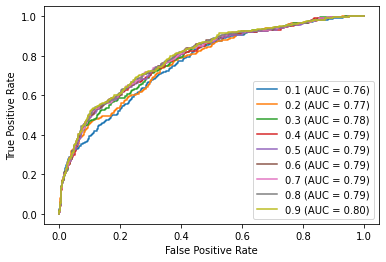

In [33]:
# Logit model
AUC = trainset_variation(logit, X, y)

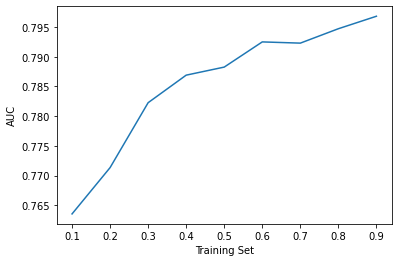

In [34]:
# Plot AUC and corresponding size of the set the model is built on
plt.plot( AUC['train_set_size'], AUC['AUC'])
plt.xlabel('Training Set')
plt.ylabel('AUC');

Looking at this plot, do you think logit is sensitive toward the size of the training set?
<br> <br>
**Answer:** We can see the model being sensitive to the size of the training data. It is important to note that our AUC did, however, only vary between about 0.75 and 0.8, but they can make a significant difference in real life. Furthermore, the size of your training set should always depend on the size of your data set. 
Generally, we can see a pretty steady increase in performance with the growing size of the training set. We see a few fluctuations an also not a stronger increase at the start. This table reveals that model performance is sensitive to the size of the training set. 
<br> <br>
**Optional:** you could also repeat the above task and create a plot for a decision tree model. This would facilitate comparing the 'hunger' for data between logit and trees.


Model trained on: 10 % of the data set
The AUC on the test set of this model is: 0.8527

Model trained on: 20 % of the data set
The AUC on the test set of this model is: 0.8614

Model trained on: 30 % of the data set
The AUC on the test set of this model is: 0.8559

Model trained on: 40 % of the data set
The AUC on the test set of this model is: 0.8701

Model trained on: 50 % of the data set
The AUC on the test set of this model is: 0.8768

Model trained on: 60 % of the data set
The AUC on the test set of this model is: 0.8748

Model trained on: 70 % of the data set
The AUC on the test set of this model is: 0.8835

Model trained on: 80 % of the data set
The AUC on the test set of this model is: 0.8936

Model trained on: 90 % of the data set
The AUC on the test set of this model is: 0.8938



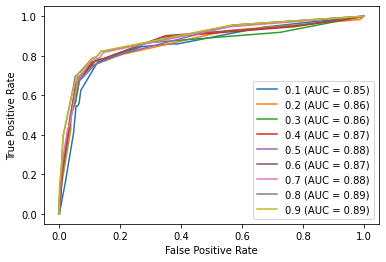

In [35]:
# Tree model
AUC = trainset_variation(tree, X, y)

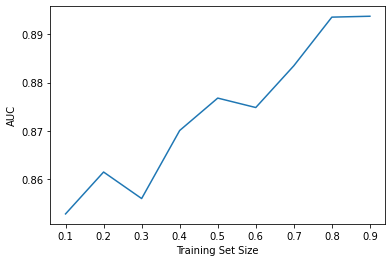

In [36]:
plt.plot( AUC['train_set_size'], AUC['AUC'])
plt.xlabel('Training Set Size')
plt.ylabel('AUC');

**Answer:** In the tree model, we observe a range of AUC values between 0.85 and 0.90. Similar to the logit model, we can generally identify an increase of model performance with a growing training set. We do see some inconsistencies, where the performance drops a little, but fluctuations may arise, especially when the training set includes fewer observations. Remember that we pick a fraction of observations randomly. The smaller the number, the higher the impact of a randomly chosen observations.
___


10. Familiarize yourself with the `StratifiedKFold()` function of `sklean`. We want to use this function to create 5 splits. Use the  ` cross_validate()` function to calculate the corresponding average AUC. Compare the results to the ones in task 4.



In [37]:
# Import libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate 

# Specify StatifiedKFold function with 5 splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=888)


In [38]:
# Tree Model

# Calculate score using skf as input
score_tree = pd.DataFrame(cross_validate(tree, X, y, scoring= 'roc_auc', cv=skf))
score_tree

# Print results and the AUC value from task 4
print('The AUC on the test set for the stratified KFold is: {:.4f}'.format(sum(score_tree.test_score) / len(score_tree.test_score)))
print('The AUC on the test set from task 4 is: {:.4f}'.format(tsk_4_auc_tree))

The AUC on the test set for the stratified KFold is: 0.8606
The AUC on the test set from task 4 is: 0.7923


In [39]:
score_logit = pd.DataFrame(cross_validate(logit, X, y, scoring= 'roc_auc', cv=skf))
score_logit

print('The AUC on the test set for the stratified KFold is: {:.4f}'.format(sum(score_logit.test_score) / len(score_logit.test_score)))
print('The AUC on the test set from task 4 is: {:.4f}'.format(tsk_4_auc_logit))

The AUC on the test set for the stratified KFold is: 0.7858
The AUC on the test set from task 4 is: 0.8835


Which model performed better? How do you explain these results? Read up on this function. How does it work and why would you use it?
<br> <br>
**Answer:**We find very conflicting results for both models. The tree model shows a higher accuracy using the `StatifiedKFold()` function. The logit model shows the opposite result, with the AUC of task 4 being higher. So which one is better? For our data set, it is better to use the `StatifiedKFold()` function. While having high AUC values is good, it is important to see whether it is representative in this setting.

[Read up on the documentation of this function here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) <br>
One quote from this site is the following:
<br>
"The implementation is designed to generate test sets such that all contain the same distribution of classes, or as close as possible."

This means that our test set is generally more representatitive of the observed distribution between good's and bad's. This is important as the distribution of classes can heavily impact predictions. Generally, it is better to have a more representative model with lower AUC values. It is more likely to achieve similar results for novel data instances, such as the real world. 

___
# Well done!! You have reached the end of this exercise.